In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output
from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap, ZFeatureMap

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42

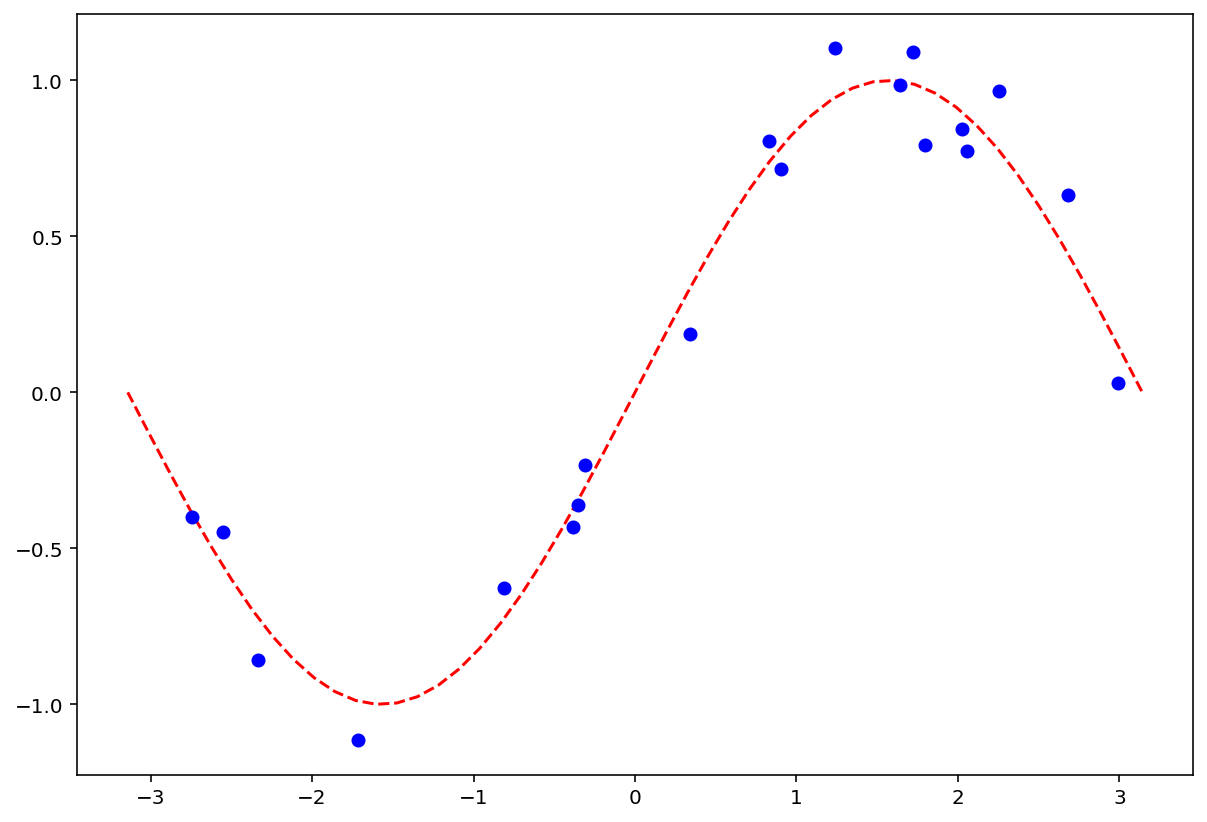

In [2]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

In [3]:
X.shape

(20, 1)

In [4]:
y.shape

(20,)

In [5]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [6]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)

In [7]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [8]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    #optimizer=L_BFGS_B(),
    optimizer=COBYLA(400),
    callback=callback_graph,
)

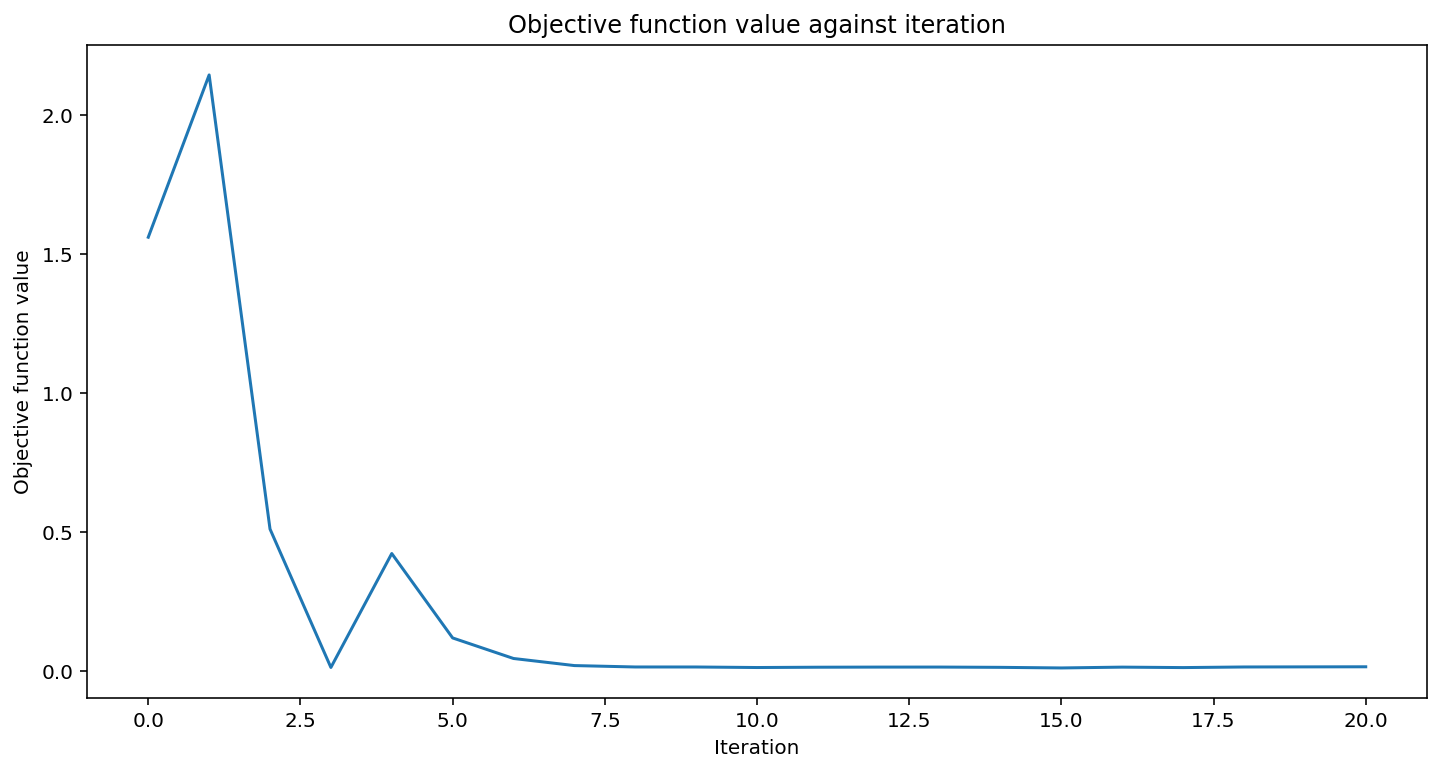

0.9754691641875919

In [9]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score the result
regressor.score(X, y)

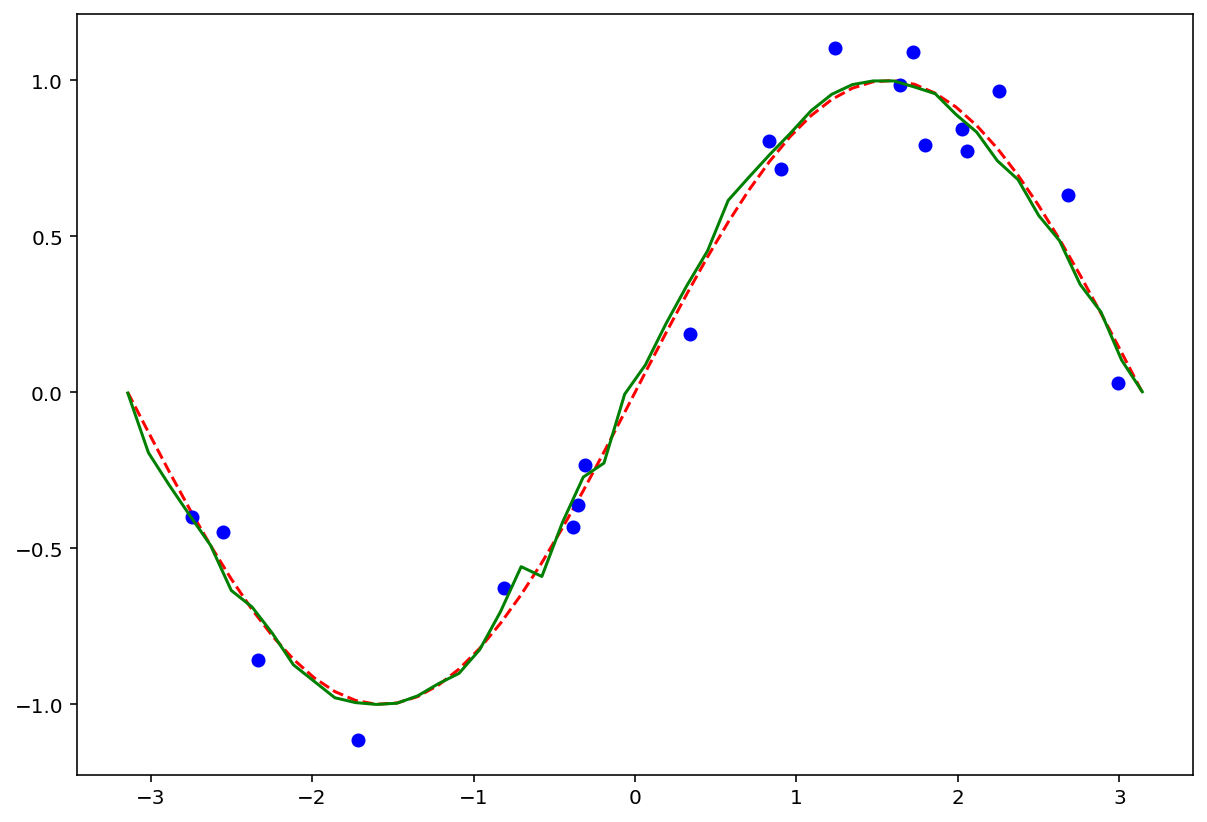

In [10]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [11]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

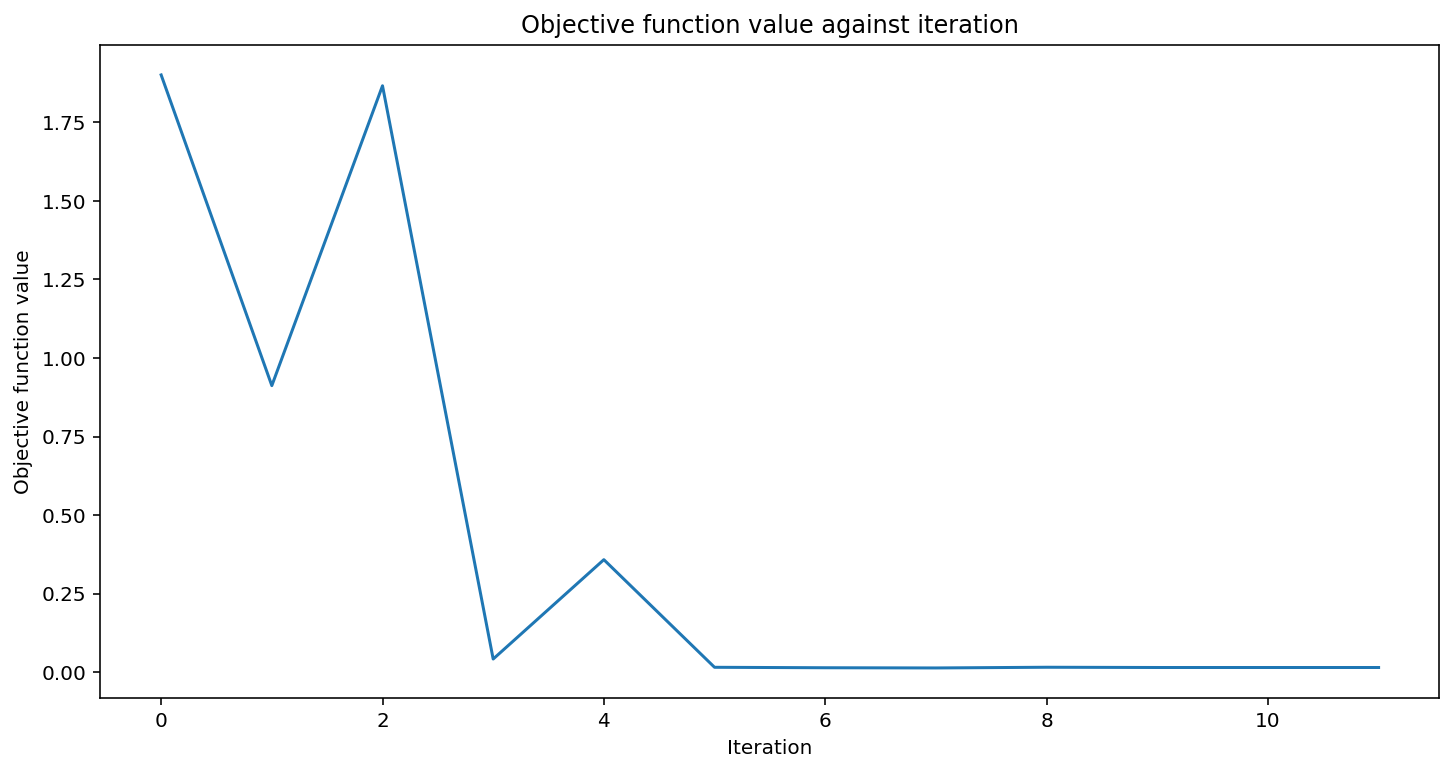

0.9743196076668185

In [12]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score result
vqr.score(X, y)

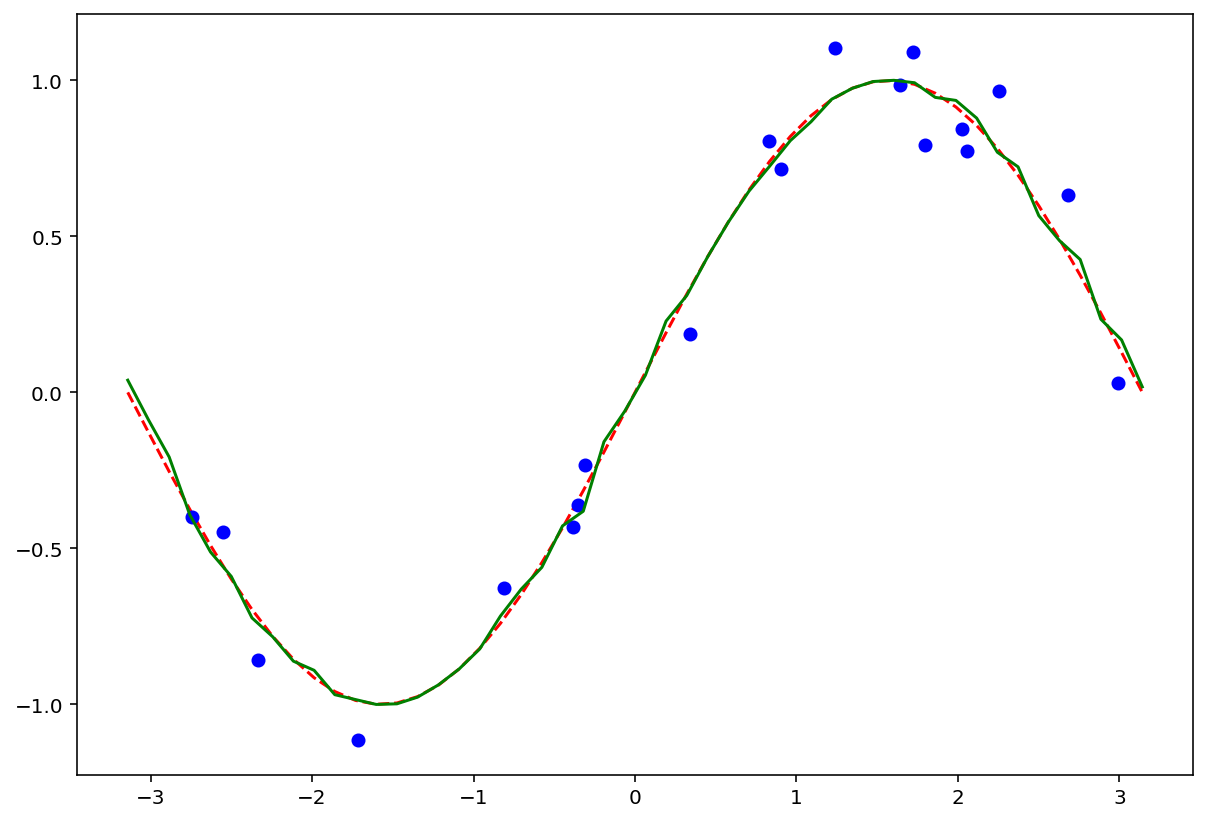

In [13]:
plt.rcParams['figure.figsize'] = [10, 7]

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

## Quantum Support Vector Regressor (Best Approach)

In [14]:
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

qsvr = QSVR(quantum_kernel=qkernel)
qsvr.fit(X, y)

QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x000001DE3BE70788>,
     shrinking=True, tol=0.001, verbose=False)

In [15]:
qsvr.predict(X_)

array([ 0.04993677, -0.07862629, -0.24835843, -0.31567951, -0.44334001,
       -0.53694504, -0.67942071, -0.77779785, -0.86961929, -0.90541558,
       -0.93783902, -0.93326194, -1.03166198, -1.0506584 , -1.01167874,
       -0.96898101, -0.96234971, -0.84813033, -0.77992021, -0.7294571 ,
       -0.58613108, -0.49349558, -0.38252871, -0.23879679, -0.07709759,
        0.05696771,  0.16982282,  0.32337057,  0.43571348,  0.51721264,
        0.61852105,  0.76138325,  0.85294367,  0.93203498,  0.93825374,
        1.03738793,  0.99516832,  1.00308719,  1.03018164,  0.96960677,
        0.90039786,  0.93639843,  0.84904677,  0.7531586 ,  0.67912509,
        0.44853047,  0.41607294,  0.29504679,  0.15126888,  0.06030511])

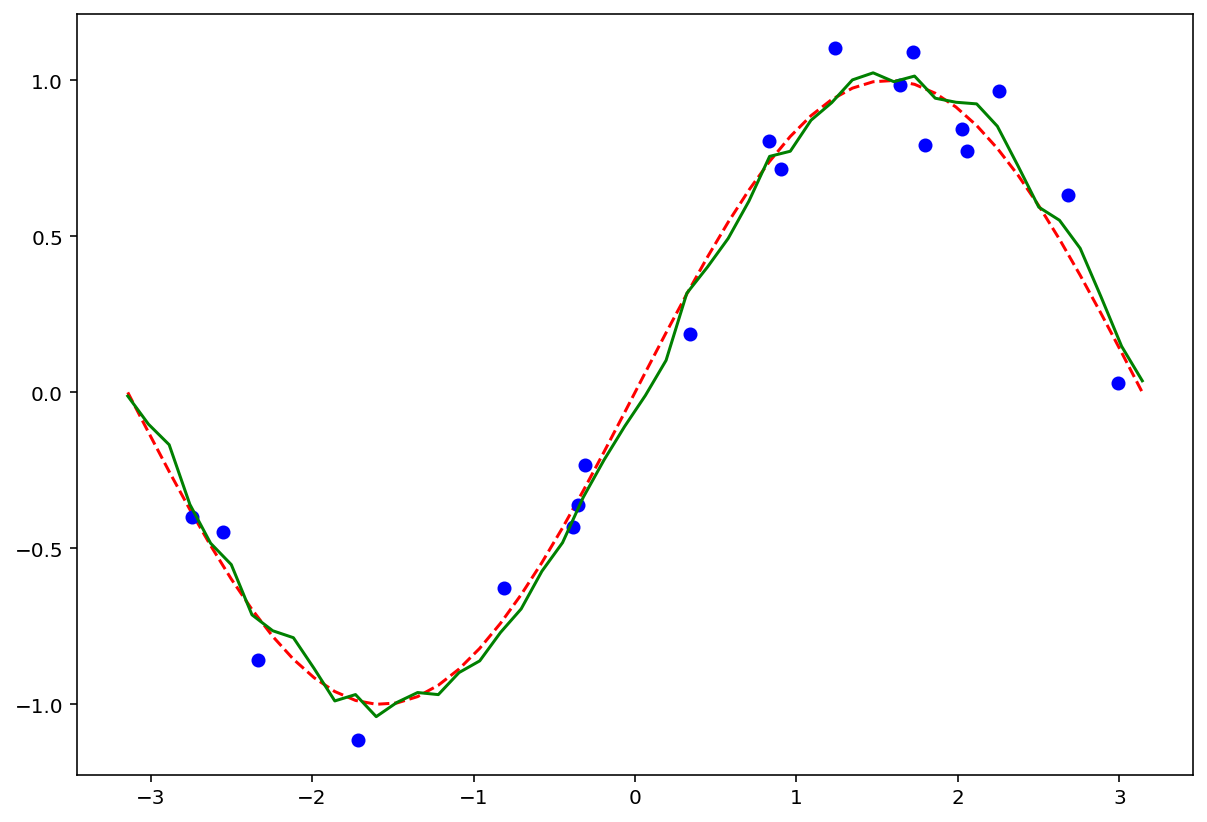

In [16]:
plt.rcParams['figure.figsize'] = [10, 7]

# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = qsvr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()